In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy import stats
import psycopg2
from sqlalchemy import create_engine

In [41]:
class TAXI:
    # ===== INITIALIZING OR CONSTRUCTOR =====#
    
    def __init__(self, filepath):
        
        self.filepath = filepath            # Store the file path
        self.data = pd.read_csv(filepath, low_memory=False)   # Load CSV into a DataFrame
        
    # ===== BASIC INSPECTION ===== #   

    """ Displays dataset """
    def Dataframe(self):
        return self.data
    
    """ display first 5 rows """
    def Show_head(self):
        return self.data.head()

    """ indexing """  
    def Index(self):
        return self.data.index

    """ columns in dataframe """
    def Columns(self):
        return self.data.columns

    """ data types in dataframe """
    def Selected_dtypes(self):
        return self.data.select_dtypes(include= ['float64'])

    """ display last 5 rows """
    def Show_tail(self):
        return self.data.tail()

    """ checking the dataframe is empty or not """
    def Empty(self):
        return self.data.empty

    """ checking for unique values """
    def Unique(self):
        return self.data.nunique()

    """ data information """
    def Data_info(self):
        return self.data.info()

    # ===== DATA CLEANING ===== #
    
    """ null values count """
    def Count_nulls(self):
        return self.data.isnull().sum()

    """ null values percentage """
    def Null_percentage(self):
        return self.data.isnull().mean()*100
     
    """Fill missing values in numeric columns with their mean """  
    def Filling_columns(self):
        # selecting numeric datatypes
        numeric_cols = self.data.select_dtypes(include=['number']).columns
        #imputing with mean
        for col in numeric_cols:
            if self.data[col].isnull().any():  # only process if there are NaNs
                self.data[col] = self.data[col].fillna(self.data[col].mean())
        
        return self.data

    """ Fill missing values in object/categorical columns with their mode """
    def Fill_object_columns(self):
        # selecting object datatypes
        object_cols = self.data.select_dtypes(include=['object', 'category']).columns
        # imputing with mode
        for col in object_cols:
            if self.data[col].isnull().any():  # only if there are NaNs
                mode_val = self.data[col].mode().iloc[0] if not self.data[col].mode().empty else None
                self.data[col] = self.data[col].fillna(mode_val)
        
        return self.data

    """ drop duplicates """
    def Drop_duplicates(self):
        self.data.drop_duplicates()
        return

    # ===== DATA TRANSFORMATION ===== #

    """ average fare per passenger count """
    def Avg_fare_count(self, col1, col2):
        return self.data.groupby(col1)[col2].mean().reset_index()
        
    """ passenger counts """
    def Pass_count(self,col):
        return self.data[col].value_counts()
        
    """ most common trip distance """
    def Common_trip(self, col):
        return self.data[col].mode()[0]
        
    """ largest trip distance """
    def Largest_trip(self,col):
        return self.data.nlargest(10,col)
    
    """ average fare amount per trip """
    def Avg_per_trip(self,col):
        return self.data[col].mean()
    
    """ type of payment """
    def Payment_type(self,col1,col2):
        return self.data.groupby(col1)[col2].mean()
    
    """ sort values by trip_distance """
    def Trip_distance(self,col):
        return self.data.sort_values(by = col)
    
    """ filtering the columns """
    def Filter_columns(self,columns):
        return self.data.filter(items = columns)

        
    # ===== STATISTICAL ANALYSIS ===== #
    
    """ Statistical information """
    def Stat_info(self):
        return self.data.describe()

    """ Measures of central tendency """
    def Statistical_measures(self):
        numeric_cols = self.data.select_dtypes(include=['int64', 'float64']).columns
        measures = []
    
        for col in numeric_cols:
            measures.append({
            'Column': col,
            'Mean': self.data[col].mean(),
            'Median': self.data[col].median(),
            'Mode': self.data[col].mode()[0],
            'Variance': self.data[col].var(),
            'Std_Dev': self.data[col].std()
        })

        return pd.DataFrame(measures)

    """ correlation between two columns """
    def Corr_coef(self,col1,col2):
        return np.corrcoef(self.data[col1],self.data[col2])[0][1]

    """ correlation among all the numeric columns with target """
    # correlation among the columns with target column
    # integer columns
    def Correlation(self,column):
        continious_var = self.data.select_dtypes(include=['int64','float64']).columns.tolist()
        correlated = []
        target = column

        for col in continious_var:
            if col != target:  #  comparing all continious variable columns  with target
                result = np.corrcoef(self.data[col], self.data[target])[0][1]
                if abs(result) :
                    correlated.append((col, target, round(result, 3)))
            
        # Print results
        for pair in correlated:
            print(f"{pair[0]} vs {pair[1]}  => correlation: {pair[2]}")

        return 

    
    """ One-way ANOVA test between two or more numeric columns """
    def Anova_two_cols(self, *cols):
        try:
            # Extract groups
            groups = [self.data[col].dropna().values for col in cols]

            if len(groups) < 2:
                print("At least 2 columns are required for ANOVA.")
                return None

            # Run ANOVA
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"ANOVA on {cols}: F = {f_stat:.3f}, p = {p_val:.3e}")
            return f_stat, p_val

        except Exception as e:
            print(f"Error running ANOVA: {e}")
            return None

    

    """ calculating outliers """
    def Outliers(self, col):
        Q1 = self.data[col].quantile(0.25)
        Q3 = self.data[col].quantile(0.75)
        IQR = Q3 - Q1 # inter quartile range
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    
        outliers = self.data[(self.data[col] < lower_bound) | (self.data[col] > upper_bound)]
        print(f"Lower Bound: {lower_bound}")
        print(f"Upper Bound: {upper_bound}")
        print(f"Number of outliers: {len(outliers)}")
        return

    # ===== PLOTTING METHODS ===== #

    """ Correlation Heatmap """
    def Correlation_Heatmap(self,cols):
        # Select numeric columns 
        corr = self.data[cols].corr()
        plt.figure(figsize=(10,6))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation'})
        plt.title("Correlation Heatmap of Taxi Metrics", fontsize=14, weight="bold")
        plt.yticks(rotation=0)
        plt.show()


    """ Histogram / Distribution """
    def Histogram(self, col):
        plt.figure(figsize=(8,5))
        sns.histplot(self.data[col], bins=50, kde=True, color="skyblue")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

    """ Boxplot """
    def Boxplot(self, x=None, y=None, color="orange", figsize=(8,5)):
        plt.figure(figsize=figsize)

        # Case 1: Single variable
        if y is None and x is not None:
            sns.boxplot(x=self.data[x], color=color)

        # Case 2: Category vs Numeric
        elif x is not None and y is not None:
            sns.boxplot(x=self.data[x], y=self.data[y], palette="Set2")

        else:
            raise ValueError("Provide either x, or both x and y columns.")

        plt.title("Boxplot", fontsize=14, weight="bold")
        plt.xlabel(x if x else "", fontsize=12)
        if y:
            plt.ylabel(y, fontsize=12)
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()

    """ Boxplot """
    def Boxplot(self, x=None, y=None, color="orange", figsize=(8,5)):
        plt.figure(figsize=figsize)

        # Case 1: Single variable
        if y is None and x is not None:
            sns.boxplot(x=self.data[x], color=color)

        # Case 2: Category vs Numeric
        elif x is not None and y is not None:
            sns.boxplot(x=self.data[x], y=self.data[y], hue=self.data[x], 
                        palette="Set2", legend=False)

        else:
            raise ValueError("Provide either x, or both x and y columns.")

        plt.title("Boxplot", fontsize=14, weight="bold")
        plt.xlabel(x if x else "", fontsize=12)
        if y:
            plt.ylabel(y, fontsize=12)
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()

    """ Violin Plot """
    def Violinplot(self, x=None, y=None, color="lightgreen", figsize=(8,5)):
        plt.figure(figsize=figsize)

        # Case 1: Single variable
        if y is None and x is not None:
            sns.violinplot(x=self.data[x], color=color)

        # Case 2: Category vs Numeric
        elif x is not None and y is not None:
            sns.violinplot(x=self.data[x], y=self.data[y], hue=self.data[x], 
                           palette="Set2", legend=False)

        else:
            raise ValueError("Provide either x, or both x and y columns.")

        plt.title("Violin Plot", fontsize=14, weight="bold")
        plt.xlabel(x if x else "", fontsize=12)
        if y:
            plt.ylabel(y, fontsize=12)
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()


    
    """ Scatter Plot (Relationship between two numeric columns) """
    def Scatterplot(self, col1, col2):
        plt.figure(figsize=(8,5))
        sns.scatterplot(data=self.data, x=col1, y=col2, alpha=0.3)
        plt.title(f"Scatter Plot: {col1} vs {col2}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()

        """ Line Plot (x vs y) """
    def Lineplot(self, x, y, figsize=(8,5)):
        plt.figure(figsize=figsize)
        sns.lineplot(data=self.data, x=x, y=y, marker="o")
        plt.title(f"Line Plot: {y} vs {x}", fontsize=14, weight="bold")
        plt.xlabel(x, fontsize=12)
        plt.ylabel(y, fontsize=12)
        plt.grid(axis="both", linestyle="--", alpha=0.6)
        plt.show()


    """ Bar Plot (numeric x vs numeric y) """
    def Barplot(self, x, y, aggfunc="mean", color="skyblue", figsize=(8,5)):
        plt.figure(figsize=figsize)
        grouped = self.data.groupby(x)[y].agg(getattr(np, aggfunc)).reset_index()
        sns.barplot(data=grouped, x=x, y=y, color=color)
        plt.title(f"Bar Plot: {aggfunc.capitalize()} of {y} by {x}", fontsize=14, weight="bold")
        plt.xlabel(x, fontsize=12)
        plt.ylabel(f"{aggfunc.capitalize()} of {y}", fontsize=12)
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()


    """ Connecting python to postgresql """
    """ ------------------ POSTGRESQL INTEGRATION ------------------ """
    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"
            
            
    """ Generates SQL CREATE TABLE statement based on DataFrame column dtypes"""
    def generate_create_table_statement(self, table_name="taxi_data"):
        """  SQL CREATE TABLE statement """
        columns = self.data.dtypes
        sql_columns = ",\n    ".join([f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()])
        create_stmt = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
        {sql_columns}
        );
        """
        return create_stmt


    def save_to_postgres(self, conn_params, table_name="taxi_data"):
        """
        Creates table and inserts DataFrame records into PostgreSQL.
        Name of the PostgreSQL table "taxi_data".
        """
        create_stmt = self.generate_create_table_statement(table_name)

        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            
            # Create the table
            cur.execute(create_stmt)
            conn.commit()
            
            # Prepare insert statement
            columns = list(self.data.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
            INSERT INTO {table_name} ({', '.join(['"{}"'.format(col) for col in columns])})
            VALUES ({placeholders})
            """
            # Insert data row by row
            for _, row in self.data.iterrows():
                cur.execute(insert_stmt, tuple(row))
            conn.commit()
            
            cur.close()
            conn.close()
            print(f"Data inserted successfully into table {table_name}")
            
        except Exception as e:
            print(f"Error during PostgreSQL operation: {e}")

                    
    """ Reads data from a PostgreSQL table and returns a Pandas DataFrame """
    def read_from_postgresql(self, conn_params=None, table_name="taxi_data"):
        
        if conn_params is None:
            conn_params = {
                'dbname': "postgres",
                'user': "postgres",
                'password': "postgres",
                'host': "localhost",
                'port': "5432"
            }

        try:
            conn = psycopg2.connect(**conn_params)
            query = f'SELECT * FROM {table_name}'
            df = pd.read_sql(query, conn)
            conn.close()
            return df
        except Exception as e:
            print(f" Error reading from PostgreSQL: {e}")
            return None


In [42]:
# Object creation
obj = TAXI("Taxi_Trip_Data.csv")

# BASIC INSPECTION

In [4]:
# Dataframe
obj.Dataframe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1.0,1.20,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.00,0.3,11.27,2.5
1,1.0,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1.0,1.20,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.00,0.3,12.30,2.5
2,1.0,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1.0,0.60,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.00,0.3,10.80,2.5
3,1.0,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1.0,0.80,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.00,0.3,8.16,0.0
4,2.0,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1.0,0.00,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.00,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499995,2.0,02/01/2020 12:52:43 PM,02/01/2020 01:02:11 PM,1.0,1.21,1.0,N,238,239,1.0,7.5,0.0,0.5,2.16,0.00,0.3,14.91,2.5
6499996,2.0,02/01/2020 12:38:19 PM,02/01/2020 01:19:03 PM,1.0,17.77,2.0,N,132,100,1.0,52.0,0.0,0.5,12.28,6.12,0.3,73.70,2.5
6499997,2.0,02/01/2020 12:12:39 PM,02/01/2020 12:25:20 PM,1.0,3.57,1.0,N,13,33,1.0,13.5,0.0,0.5,3.36,0.00,0.3,20.16,2.5
6499998,2.0,02/01/2020 12:42:47 PM,02/01/2020 01:09:27 PM,1.0,5.85,1.0,N,209,230,2.0,23.5,0.0,0.5,0.00,0.00,0.3,26.80,2.5


In [5]:
# starting 5 rows
obj.Show_head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


In [6]:
# indexing
obj.Index()

RangeIndex(start=0, stop=6500000, step=1)

In [7]:
# columns 
obj.Columns()

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

In [8]:
# datatypes
obj.Selected_dtypes()

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,1.0,1.20,1.0,1.0,6.0,3.0,0.5,1.47,0.00,0.3,11.27,2.5
1,1.0,1.0,1.20,1.0,1.0,7.0,3.0,0.5,1.50,0.00,0.3,12.30,2.5
2,1.0,1.0,0.60,1.0,1.0,6.0,3.0,0.5,1.00,0.00,0.3,10.80,2.5
3,1.0,1.0,0.80,1.0,1.0,5.5,0.5,0.5,1.36,0.00,0.3,8.16,0.0
4,2.0,1.0,0.00,1.0,2.0,3.5,0.5,0.5,0.00,0.00,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499995,2.0,1.0,1.21,1.0,1.0,7.5,0.0,0.5,2.16,0.00,0.3,14.91,2.5
6499996,2.0,1.0,17.77,2.0,1.0,52.0,0.0,0.5,12.28,6.12,0.3,73.70,2.5
6499997,2.0,1.0,3.57,1.0,1.0,13.5,0.0,0.5,3.36,0.00,0.3,20.16,2.5
6499998,2.0,1.0,5.85,1.0,2.0,23.5,0.0,0.5,0.00,0.00,0.3,26.80,2.5


In [9]:
# last 5 elements
obj.Show_tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
6499995,2.0,02/01/2020 12:52:43 PM,02/01/2020 01:02:11 PM,1.0,1.21,1.0,N,238,239,1.0,7.5,0.0,0.5,2.16,0.00,0.3,14.91,2.5
6499996,2.0,02/01/2020 12:38:19 PM,02/01/2020 01:19:03 PM,1.0,17.77,2.0,N,132,100,1.0,52.0,0.0,0.5,12.28,6.12,0.3,73.70,2.5
6499997,2.0,02/01/2020 12:12:39 PM,02/01/2020 12:25:20 PM,1.0,3.57,1.0,N,13,33,1.0,13.5,0.0,0.5,3.36,0.00,0.3,20.16,2.5
6499998,2.0,02/01/2020 12:42:47 PM,02/01/2020 01:09:27 PM,1.0,5.85,1.0,N,209,230,2.0,23.5,0.0,0.5,0.00,0.00,0.3,26.80,2.5
6499999,2.0,02/01/2020 12:02:24 PM,02/01/2020 12:13:36 PM,4.0,1.89,1.0,N,142,236,1.0,9.5,0.0,0.5,2.56,0.00,0.3,15.36,2.5


In [10]:
# checking empty or not
obj.Empty()

False

In [11]:
# unique values column wise
obj.Unique()

VendorID                       2
tpep_pickup_datetime     2179585
tpep_dropoff_datetime    2182584
passenger_count               10
trip_distance               5626
RatecodeID                     7
store_and_fwd_flag             2
PULocationID                 261
DOLocationID                 262
payment_type                   5
fare_amount                 5931
extra                         47
mta_tax                       11
tip_amount                  3644
tolls_amount                1041
improvement_surcharge          3
total_amount               12609
congestion_surcharge           8
dtype: int64

In [12]:
# data information
obj.Data_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500000 entries, 0 to 6499999
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(13), int64(2), object(3)
memory usage: 892.6+ MB


# DATA CLEANING

In [13]:
# counting null values
obj.Count_nulls()

VendorID                 79229
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          79229
trip_distance                0
RatecodeID               79229
store_and_fwd_flag       79229
PULocationID                 0
DOLocationID                 0
payment_type             79229
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge         0
dtype: int64

In [14]:
# nulls percentage
obj.Null_percentage()

VendorID                 1.218908
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          1.218908
trip_distance            0.000000
RatecodeID               1.218908
store_and_fwd_flag       1.218908
PULocationID             0.000000
DOLocationID             0.000000
payment_type             1.218908
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.000000
dtype: float64

In [15]:
# fill null values
obj.Filling_columns()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1.0,1.20,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.00,0.3,11.27,2.5
1,1.0,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1.0,1.20,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.00,0.3,12.30,2.5
2,1.0,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1.0,0.60,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.00,0.3,10.80,2.5
3,1.0,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1.0,0.80,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.00,0.3,8.16,0.0
4,2.0,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1.0,0.00,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.00,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499995,2.0,02/01/2020 12:52:43 PM,02/01/2020 01:02:11 PM,1.0,1.21,1.0,N,238,239,1.0,7.5,0.0,0.5,2.16,0.00,0.3,14.91,2.5
6499996,2.0,02/01/2020 12:38:19 PM,02/01/2020 01:19:03 PM,1.0,17.77,2.0,N,132,100,1.0,52.0,0.0,0.5,12.28,6.12,0.3,73.70,2.5
6499997,2.0,02/01/2020 12:12:39 PM,02/01/2020 12:25:20 PM,1.0,3.57,1.0,N,13,33,1.0,13.5,0.0,0.5,3.36,0.00,0.3,20.16,2.5
6499998,2.0,02/01/2020 12:42:47 PM,02/01/2020 01:09:27 PM,1.0,5.85,1.0,N,209,230,2.0,23.5,0.0,0.5,0.00,0.00,0.3,26.80,2.5


In [16]:
# filling in objects columns
obj.Fill_object_columns()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1.0,1.20,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.00,0.3,11.27,2.5
1,1.0,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1.0,1.20,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.00,0.3,12.30,2.5
2,1.0,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1.0,0.60,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.00,0.3,10.80,2.5
3,1.0,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1.0,0.80,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.00,0.3,8.16,0.0
4,2.0,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1.0,0.00,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.00,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499995,2.0,02/01/2020 12:52:43 PM,02/01/2020 01:02:11 PM,1.0,1.21,1.0,N,238,239,1.0,7.5,0.0,0.5,2.16,0.00,0.3,14.91,2.5
6499996,2.0,02/01/2020 12:38:19 PM,02/01/2020 01:19:03 PM,1.0,17.77,2.0,N,132,100,1.0,52.0,0.0,0.5,12.28,6.12,0.3,73.70,2.5
6499997,2.0,02/01/2020 12:12:39 PM,02/01/2020 12:25:20 PM,1.0,3.57,1.0,N,13,33,1.0,13.5,0.0,0.5,3.36,0.00,0.3,20.16,2.5
6499998,2.0,02/01/2020 12:42:47 PM,02/01/2020 01:09:27 PM,1.0,5.85,1.0,N,209,230,2.0,23.5,0.0,0.5,0.00,0.00,0.3,26.80,2.5


In [17]:
# null count
obj.Count_nulls()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
dtype: int64

In [18]:
# deleting duplicates
obj.Drop_duplicates

<bound method TAXI.Drop_duplicates of <__main__.TAXI object at 0x0000017395683CB0>>

In [19]:
# avg fare by passenger count
obj.Avg_fare_count("passenger_count","fare_amount")

,passenger_count,fare_amount
0,0.000000,12.199888
1,1.000000,12.375398
2,1.515719,32.938818
3,2.000000,12.953100
4,3.000000,12.739297
5,4.000000,13.194714
6,5.000000,12.220464
7,6.000000,12.345364
8,7.000000,62.008276
9,8.000000,49.745882


In [20]:
# passenger count
obj.Pass_count("passenger_count")

passenger_count
1.000000    4604359
2.000000     959137
3.000000     253553
5.000000     228784
6.000000     133978
4.000000     125124
0.000000     115771
1.515719      79229
7.000000         29
9.000000         19
8.000000         17
Name: count, dtype: int64

In [21]:
# common trip distance
obj.Common_trip("trip_distance")

np.float64(0.9)

In [22]:
# largest trip
obj.Largest_trip("trip_distance")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
6412080,1.669844,01/28/2020 07:37:00 AM,01/28/2020 08:42:00 AM,1.515719,210240.07,1.059781,N,76,231,1.270356,37.77,2.75,0.5,0.00,0.00,0.3,41.32,0.0
3507112,1.669844,07/16/2020 07:31:00 AM,07/16/2020 08:11:00 AM,1.515719,38184.62,1.059781,N,4,236,1.270356,18.32,0.00,0.5,2.00,0.00,0.3,23.62,2.5
2159326,2.000000,01/12/2020 09:19:23 AM,01/12/2020 01:49:59 PM,4.000000,262.88,5.000000,N,132,265,1.000000,600.00,0.00,0.0,0.00,55.55,0.3,658.35,2.5
566885,2.000000,01/04/2020 12:52:02 PM,01/04/2020 05:23:52 PM,4.000000,259.22,5.000000,N,140,265,2.000000,575.00,0.00,0.0,0.00,0.00,0.3,577.80,2.5
3821579,2.000000,01/20/2020 11:31:59 AM,01/20/2020 04:08:25 PM,2.000000,241.64,1.000000,N,48,265,2.000000,614.00,0.00,0.5,0.00,0.00,0.3,617.30,2.5
1445786,1.000000,01/09/2020 12:27:13 AM,01/09/2020 03:37:32 AM,1.000000,211.70,5.000000,N,161,265,1.000000,550.00,0.00,0.0,70.00,0.00,0.3,620.30,0.0
773002,1.000000,01/05/2020 01:45:52 PM,01/05/2020 04:34:09 PM,1.000000,168.40,5.000000,N,92,265,2.000000,575.00,0.00,0.0,0.00,21.12,0.3,596.42,0.0
3363543,2.000000,01/17/2020 07:26:15 PM,01/17/2020 11:13:11 PM,1.000000,154.45,4.000000,N,262,265,2.000000,765.50,1.00,0.5,0.00,0.00,0.3,769.80,2.5
5455781,1.000000,01/28/2020 07:37:43 AM,01/28/2020 12:52:46 PM,1.000000,146.40,3.000000,N,186,228,1.000000,457.50,0.00,0.0,97.88,31.62,0.3,587.30,0.0
1253982,2.000000,01/08/2020 07:36:13 AM,01/08/2020 10:19:15 AM,1.000000,124.26,5.000000,N,219,265,1.000000,270.00,0.00,0.0,0.00,0.00,0.3,270.30,0.0


In [23]:
# avg amount pper trip
obj.Avg_per_trip("fare_amount")

np.float64(12.732547600000014)

In [24]:
# amount by oayment type
obj.Payment_type("payment_type","fare_amount")

payment_type
1.000000    12.726158
1.270356    32.938818
2.000000    11.994372
3.000000     7.933367
4.000000     0.795626
5.000000     0.000000
Name: fare_amount, dtype: float64

In [25]:
# distance order wise
obj.Trip_distance("trip_distance")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
6369257,1.669844,01/08/2020 06:00:00 AM,01/08/2020 07:07:00 AM,1.515719,-30.62,1.059781,N,117,143,1.270356,64.61,2.75,0.5,0.0,2.29,0.3,70.45,0.0
6369256,1.669844,01/08/2020 06:00:00 AM,01/08/2020 07:07:00 AM,1.515719,-30.62,1.059781,N,117,143,1.270356,64.61,2.75,0.5,0.0,2.29,0.3,70.45,0.0
6391090,1.669844,01/15/2020 05:04:00 PM,01/15/2020 06:22:00 PM,1.515719,-29.47,1.059781,N,232,86,1.270356,48.14,2.75,0.5,0.0,8.41,0.3,60.10,0.0
6354987,1.669844,01/02/2020 04:55:00 PM,01/02/2020 06:08:00 PM,1.515719,-29.23,1.059781,N,232,86,1.270356,48.14,2.75,0.5,0.0,8.41,0.3,60.10,0.0
6372679,1.669844,01/08/2020 04:58:00 PM,01/08/2020 06:12:00 PM,1.515719,-29.10,1.059781,N,232,86,1.270356,48.14,2.75,0.5,0.0,8.41,0.3,60.10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3821579,2.000000,01/20/2020 11:31:59 AM,01/20/2020 04:08:25 PM,2.000000,241.64,1.000000,N,48,265,2.000000,614.00,0.00,0.5,0.0,0.00,0.3,617.30,2.5
566885,2.000000,01/04/2020 12:52:02 PM,01/04/2020 05:23:52 PM,4.000000,259.22,5.000000,N,140,265,2.000000,575.00,0.00,0.0,0.0,0.00,0.3,577.80,2.5
2159326,2.000000,01/12/2020 09:19:23 AM,01/12/2020 01:49:59 PM,4.000000,262.88,5.000000,N,132,265,1.000000,600.00,0.00,0.0,0.0,55.55,0.3,658.35,2.5
3507112,1.669844,07/16/2020 07:31:00 AM,07/16/2020 08:11:00 AM,1.515719,38184.62,1.059781,N,4,236,1.270356,18.32,0.00,0.5,2.0,0.00,0.3,23.62,2.5


In [26]:
# filtering 
columns = ['VendorID','tpep_pickup_datetime','tpep_dropoff_datetime']
obj.Filter_columns(columns)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime
0,1.0,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM
1,1.0,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM
2,1.0,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM
3,1.0,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM
4,2.0,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM
...,...,...,...
6499995,2.0,02/01/2020 12:52:43 PM,02/01/2020 01:02:11 PM
6499996,2.0,02/01/2020 12:38:19 PM,02/01/2020 01:19:03 PM
6499997,2.0,02/01/2020 12:12:39 PM,02/01/2020 12:25:20 PM
6499998,2.0,02/01/2020 12:42:47 PM,02/01/2020 01:09:27 PM


# STATISTICAL ANALYSIS

In [27]:
# statistical information
obj.Stat_info()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06
mean,1.669844e+00,1.515719e+00,2.946476e+00,1.059781e+00,1.645881e+02,1.625559e+02,1.270356e+00,1.273255e+01,1.110699e+00,4.923319e-01,2.186040e+00,3.500850e-01,2.979841e-01,1.869325e+01,2.272097e+00
std,4.673943e-01,1.144930e+00,8.389850e+01,8.045984e-01,6.562886e+01,6.996151e+01,4.712263e-01,1.218640e+01,1.258732e+00,7.369536e-02,2.754583e+00,1.766893e+00,3.388387e-02,1.478827e+01,7.402580e-01
min,1.000000e+00,0.000000e+00,-3.062000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.238000e+03,-2.700000e+01,-5.000000e-01,-9.100000e+01,-3.574000e+01,-3.000000e-01,-1.242300e+03,-2.500000e+00
25%,1.000000e+00,1.000000e+00,9.600000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.950000e+00,0.000000e+00,3.000000e-01,1.430000e+01,2.500000e+00
75%,2.000000e+00,2.000000e+00,2.950000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.400000e+01,2.500000e+00,5.000000e-01,2.860000e+00,0.000000e+00,3.000000e-01,1.980000e+01,2.500000e+00
max,2.000000e+00,9.000000e+00,2.102401e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.265000e+03,1.130100e+02,3.080000e+01,1.100000e+03,9.105000e+02,3.000000e-01,4.268300e+03,2.750000e+00


In [28]:
# measures
obj.Statistical_measures()

,Column,Mean,Median,Mode,Variance,Std_Dev
0,VendorID,1.669844,2.00,2.0,0.218457,0.467394
1,passenger_count,1.515719,1.00,1.0,1.310864,1.144930
2,trip_distance,2.946476,1.60,0.9,7038.958798,83.898503
3,RatecodeID,1.059781,1.00,1.0,0.647379,0.804598
4,PULocationID,164.588102,162.00,237.0,4307.147587,65.628862
5,DOLocationID,162.555925,162.00,236.0,4894.612636,69.961508
6,payment_type,1.270356,1.00,1.0,0.222054,0.471226
7,fare_amount,12.732548,9.00,6.0,148.508405,12.186402
8,extra,1.110699,0.50,0.0,1.584407,1.258732
9,mta_tax,0.492332,0.50,0.5,0.005431,0.073695


In [29]:
# correlation coefficient
obj.Corr_coef("trip_distance","total_amount")

np.float64(0.03935333514093148)

In [30]:
# correlation with df
obj.Correlation("trip_distance")

VendorID vs trip_distance  => correlation: 0.001
passenger_count vs trip_distance  => correlation: 0.0
RatecodeID vs trip_distance  => correlation: 0.007
PULocationID vs trip_distance  => correlation: -0.005
DOLocationID vs trip_distance  => correlation: -0.004
payment_type vs trip_distance  => correlation: -0.001
fare_amount vs trip_distance  => correlation: 0.039
extra vs trip_distance  => correlation: 0.0
mta_tax vs trip_distance  => correlation: -0.003
tip_amount vs trip_distance  => correlation: 0.022
tolls_amount vs trip_distance  => correlation: 0.025
improvement_surcharge vs trip_distance  => correlation: 0.001
total_amount vs trip_distance  => correlation: 0.039
congestion_surcharge vs trip_distance  => correlation: -0.012


In [31]:
# calculating outliers
obj.Outliers("fare_amount")

Lower Bound: -4.75
Upper Bound: 25.25
Number of outliers: 642577


# VISUALIZATIONS

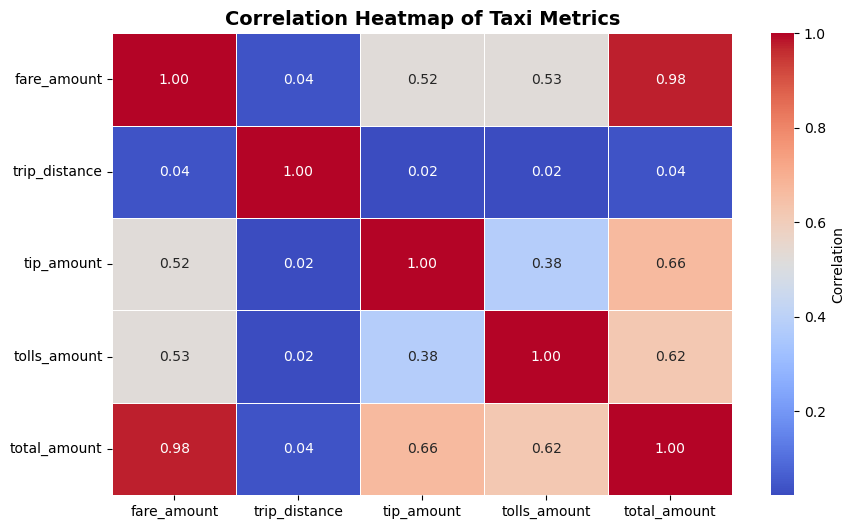

In [32]:
# heatmap
cols = ['fare_amount', 'trip_distance', 'tip_amount', 'tolls_amount', 'total_amount']
obj.Correlation_Heatmap(cols)

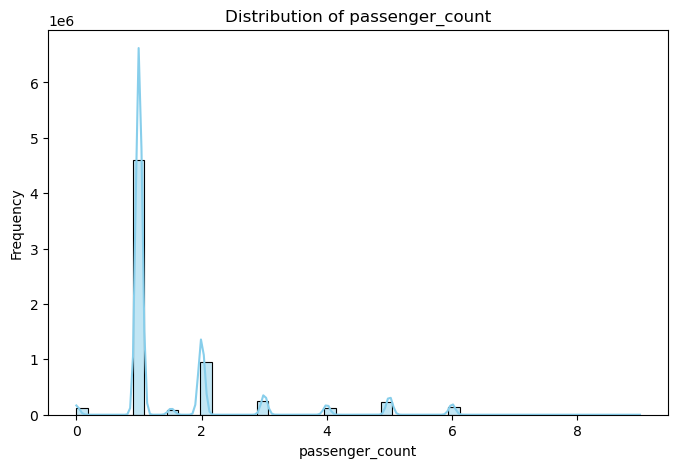

In [33]:
# histplot
obj.Histogram("passenger_count")

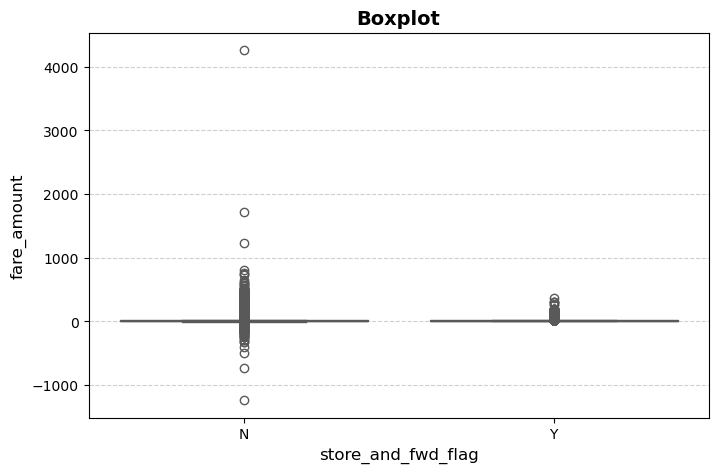

In [34]:
# store and fwd flag by amount
obj.Boxplot(x="store_and_fwd_flag", y="fare_amount")

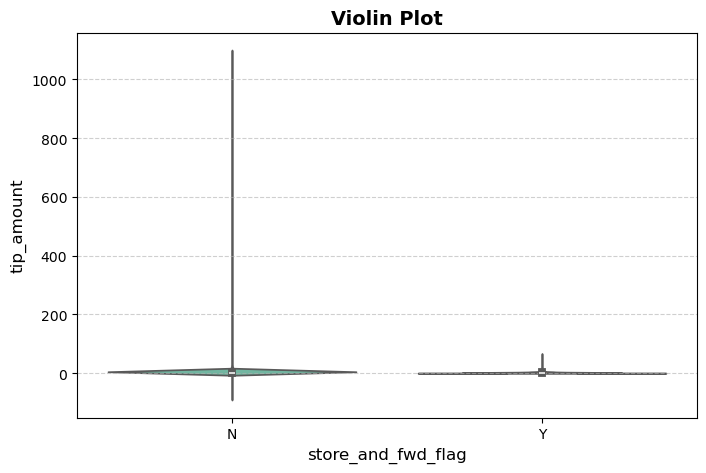

In [35]:
# store and fwd flag by tip
obj.Violinplot(x="store_and_fwd_flag", y="tip_amount")

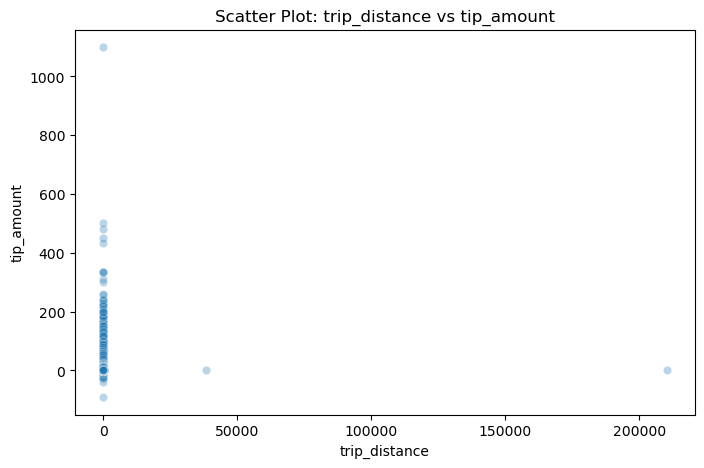

In [36]:
# distribution of tip by trip
obj.Scatterplot("trip_distance","tip_amount")

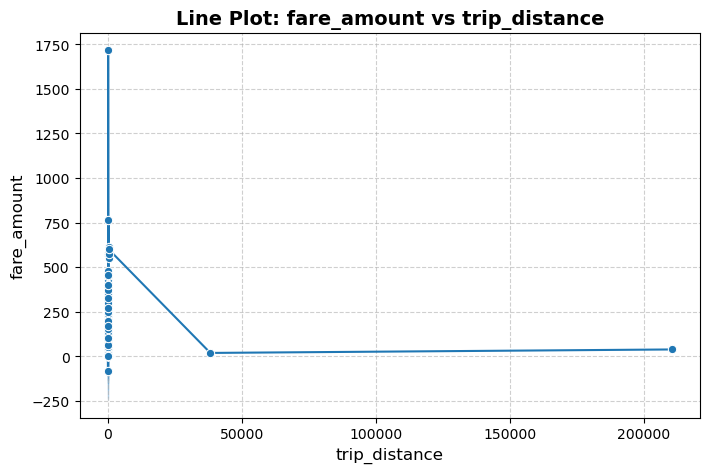

In [37]:
# Line plot: trip distance vs fare amount
obj.Lineplot(x="trip_distance", y="fare_amount")

C:\Users\rosan\AppData\Local\Temp\ipykernel_16548\2723468582.py:318: FutureWarning: The provided callable <function mean at 0x0000017395AA7A60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped = self.data.groupby(x)[y].agg(getattr(np, aggfunc)).reset_index()


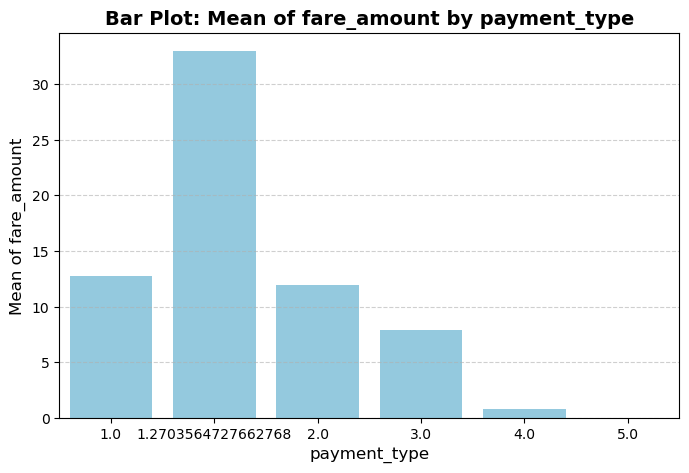

In [38]:
# avg fare by payment type
obj.Barplot(x="payment_type", y="fare_amount", aggfunc="mean")

# Connecting python to postgresql

In [44]:
print(obj.generate_create_table_statement())


        CREATE TABLE IF NOT EXISTS taxi_data (
        "VendorID" FLOAT,
    "tpep_pickup_datetime" TEXT,
    "tpep_dropoff_datetime" TEXT,
    "passenger_count" FLOAT,
    "trip_distance" FLOAT,
    "RatecodeID" FLOAT,
    "store_and_fwd_flag" TEXT,
    "PULocationID" INT,
    "DOLocationID" INT,
    "payment_type" FLOAT,
    "fare_amount" FLOAT,
    "extra" FLOAT,
    "mta_tax" FLOAT,
    "tip_amount" FLOAT,
    "tolls_amount" FLOAT,
    "improvement_surcharge" FLOAT,
    "total_amount" FLOAT,
    "congestion_surcharge" FLOAT
        );
        


In [45]:
# Inserting data into postgresql database
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "postgres",
    'host': "localhost",
    'port': "5432" 
}
obj.save_to_postgres(conn_params, table_name="taxi_data")

Data inserted successfully into table taxi_data


# Connecting postgresql to python

In [ ]:
# Reading the data from postgresql to python
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "postgres",
    'host': "localhost",  
    'port': "5432"
}
obj.read_from_postgresql(conn_params, "taxi_data")


C:\Users\rosan\AppData\Local\Temp\ipykernel_16548\4004313477.py:429: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
